In [1]:
import torch
import torch.nn.functional as F 
import torchvision.datasets as datasets 
import torchvision.transforms as transforms  
from torch import optim 
from torch import nn  
from torch.utils.data import DataLoader  
from torch.utils.data import TensorDataset  
from tqdm import tqdm 

from sympy import symbols, pi, sin, cos, simplify
from sympy.matrices import Matrix
import numpy as np
from numpy.random import default_rng
import random 
import matplotlib.pyplot as plt
import pandas as pd
import time
import math
from itertools import product as prod

In [290]:
# Comparisons 
"""
Model Level
  - 3 LayerLSTM + 1 linear 
  - 3 LayerLSTM + 1 linear + 20% dropout 
  - 3 LayerLSTM + 1 LayerNorm + 1 linear 
  - 1 layer linear 
  - 5 Layer LSTM + 1 linear

Optimizing Techniques
  - no tech
  - 20% Sparse
  - No repeat values in input 
  - 2x density input values 
  - 4x density input values 
  


5 models x 5 Tech = 25 combos

""";

In [3]:
#DH Paramater Creation
def Dh_param_matrix(a, d, Alpha, Nu):
    # a = Link Length, d = Offset, Alpha = Twist, Nu = Joint Angle
    
    return Matrix( [ [cos(Nu),-sin(Nu)*cos(Alpha), sin(Nu)*sin(Alpha),a*cos(Nu)],
                     [sin(Nu), cos(Nu)*cos(Alpha),-cos(Nu)*sin(Alpha),a*sin(Nu)],
                     [0      , sin(Alpha)        , cos(Alpha)        ,d            ],
                     [0      , 0                 , 0                 ,1            ] ] 
                 ); 
  
def Build_arm_3R(nu1,nu2,nu3):
    #Link Length in meters
    a1 = 0; a2 = 1; a3 = 1;
    #Offset
    d1 = 1; d2 = 0; d3 = 0;
    #Twist
    Alpha1 = pi/2; Alpha2 = 0; Alpha3 = 0
    #Joint Angle
    Nu1 = nu1; Nu2 = nu2; Nu3 = nu3  

    return Dh_param_matrix(a1,d1,Alpha1,Nu1)*Dh_param_matrix(a2,d2,Alpha2,Nu2)*Dh_param_matrix(a3,d3,Alpha3,Nu3);  

In [59]:
# Dataset Generator f 
Nu1, Nu2, Nu3 = symbols('Nu1:4')    
arm = Build_arm_3R(Nu1, Nu2, Nu3)

def arm_gen(x):  
    arm_out = arm.subs({Nu1: x[0], Nu2: x[1], Nu3: x[2]})
    arm_out.row_del(3)
    return arm_out,[x[0],x[1],x[2]]

In [60]:
# Generating Basic Dataset with no extra Techniques 

#Basic Density
D = 9
n = np.linspace(-np.pi,np.pi,D)
result, sequence = zip(*[arm_gen(E) for E in list(prod(n, repeat=3)) ])
print('Completed generating regular density data set with a size of {}x{}. Check -> {}={}'.format(
                                        len(result), result[0].shape, len(result), len(sequence) ) 
     )
DF = pd.DataFrame.from_records(result)

Completed generating regular density data set with a size of 729x(3, 4). Check -> 729=729


In [ ]:
#Extra Density
D = 13
n = np.linspace(-np.pi,np.pi,D)
result_extra, sequence_extra = zip(*[arm_gen(E) for E in list(prod(n, repeat=3)) ])
print('Completed generating Extra density data set with a size of {}x{}. Check -> {}={}'.format(
                len(result_extra), result_extra[0].shape, len(result_extra), len(sequence_extra) ) 
     )

#Hyper Density
D = 17
n = np.linspace(-np.pi,np.pi,D)
result_hyper, sequence_hyper = zip(*[arm_gen(E) for E in list(prod(n, repeat=3)) ])
print('Completed generating Hyper density data set with a size of {}x{}. Check -> {}={}'.format(
                len(result_hyper), result_hyper[0].shape, len(result_hyper), len(sequence_hyper) ) 
     )

In [64]:
# 20% dropout 
DF_r = pd.DataFrame.from_records(result)
DF_s = pd.DataFrame.from_records(sequence)

rng = default_rng(1234)
result_dropout = rng.choice(DF_r, 583, replace=False)
sequence_dropout =rng.choice(DF_s, 583, replace=False)
print('Completed generating Sparse density data set with a size of {}x{}. Check -> {}={}'.format(
        len(result_dropout), result_dropout.T[0].shape, len(result_dropout), len(sequence_dropout) ) 
     )

# No repeats aka filtered
result_filtered, index, = np.unique(np.array(DF_r,dtype=np.float32), return_index=True, axis=0)
sequence_filtered = np.array([sequence[a] for a in index])
print('Completed generating unique density data set with a size of {}x{}. Check -> {}={}'.format(
        len(result_filtered), result_filtered[0].shape, len(result_filtered), len(sequence_filtered) ) 
     )

Completed generating Sparse density data set with a size of 583x(583,). Check -> 583=583
Completed generating unique density data set with a size of 689x(12,). Check -> 689=689


In [211]:
# Manipulating Data
DF_r = pd.DataFrame.from_records(result)
DF_s = pd.DataFrame.from_records(sequence)


In [288]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_size = 12
hidden_size = 256
num_layers = 3
num_classes = 3
batch_size = 64
num_epochs = 100

# define the hidden dimensions of the transformer layers
# define the number of heads in the multi-head attention mechanism
num_heads = input_size
head_dim = 3
hidden_dim = num_heads * head_dim
dmodel_in = num_heads * head_dim


class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, drop=0, is_layerNorm=False):
        super(RNN_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=drop, batch_first=True)
        
        if is_layerNorm:
            self.layer_norm = nn.LayerNorm(hidden_size)
        else:
            self.layer_norm = None
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Set initial hidden and cell states        
        h0 = torch.zeros(self.num_layers, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm( x, (h0, c0) ) 
        if self.layer_norm:
            out = self.layer_norm(out)
        out = out.reshape(out.shape[0], -1)
        
        out = self.fc(out)
        return out

class RNN_Linear(nn.Module):
    def __init__(self, input_size, num_classes):
        super(RNN_Linear, self).__init__()       
        self.lin = nn.Linear(input_size, num_classes)
        
    def forward(self, x):    
        # Forward propagate Linear
        return self.lin(x)
    


# define the model
class RNN_Transformer(nn.Module):
    def __init__(self, input_dim, num_heads, hidden_dim, output_dim):
        super(RNN_Transformer, self).__init__()
        self.model = nn.Sequential(
            # first transformer layer
            nn.Transformer(
                d_model=input_dim,
                nhead=num_heads,
                dim_feedforward=hidden_dim
            ),
            # second transformer layer
            nn.Transformer(
                d_model=hidden_dim,
                nhead=num_heads,
                dim_feedforward=hidden_dim
            ),
            # third transformer layer
            nn.Transformer(
                d_model=hidden_dim,
                nhead=num_heads,
                dim_feedforward=output_dim
            )
        )
    def forward(self, input):
        # apply the transformer layers to the input
        output = self.model(input)
        return output

In [289]:
# Load Data
x_train = np.array(DF_r, dtype=np.float32)
y_train = np.array(DF_s, dtype=np.float32)

train_loader = DataLoader(dataset=TensorDataset(torch.asarray(x_train, dtype=torch.float32), 
                                                torch.asarray(y_train, dtype=torch.float32) ), 
                          batch_size=batch_size)#, shuffle=True)

# Initialize network
#model = RNN_LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
#model = RNN_Linear(input_size, num_classes).to(device)
model = RNN_Transformer(dmodel_in, num_heads, hidden_dim, num_classes).to(device)


# Loss and optimizer
criterion = nn.SmoothL1Loss() #MSELoss()
optimizer = optim.Adam(model.parameters())

lossTrack = []

# Train Network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader,disable=True)):        
        # Get data to cuda if possible
        data = data.to(device=device).squeeze(1)
        targets = targets.to(device=device)
                
        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent update step/adam step
        optimizer.step()
        
    lossTrack.append(loss.item())
        
    if (epoch+1) % 10 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

        

TypeError: forward() takes 2 positional arguments but 3 were given

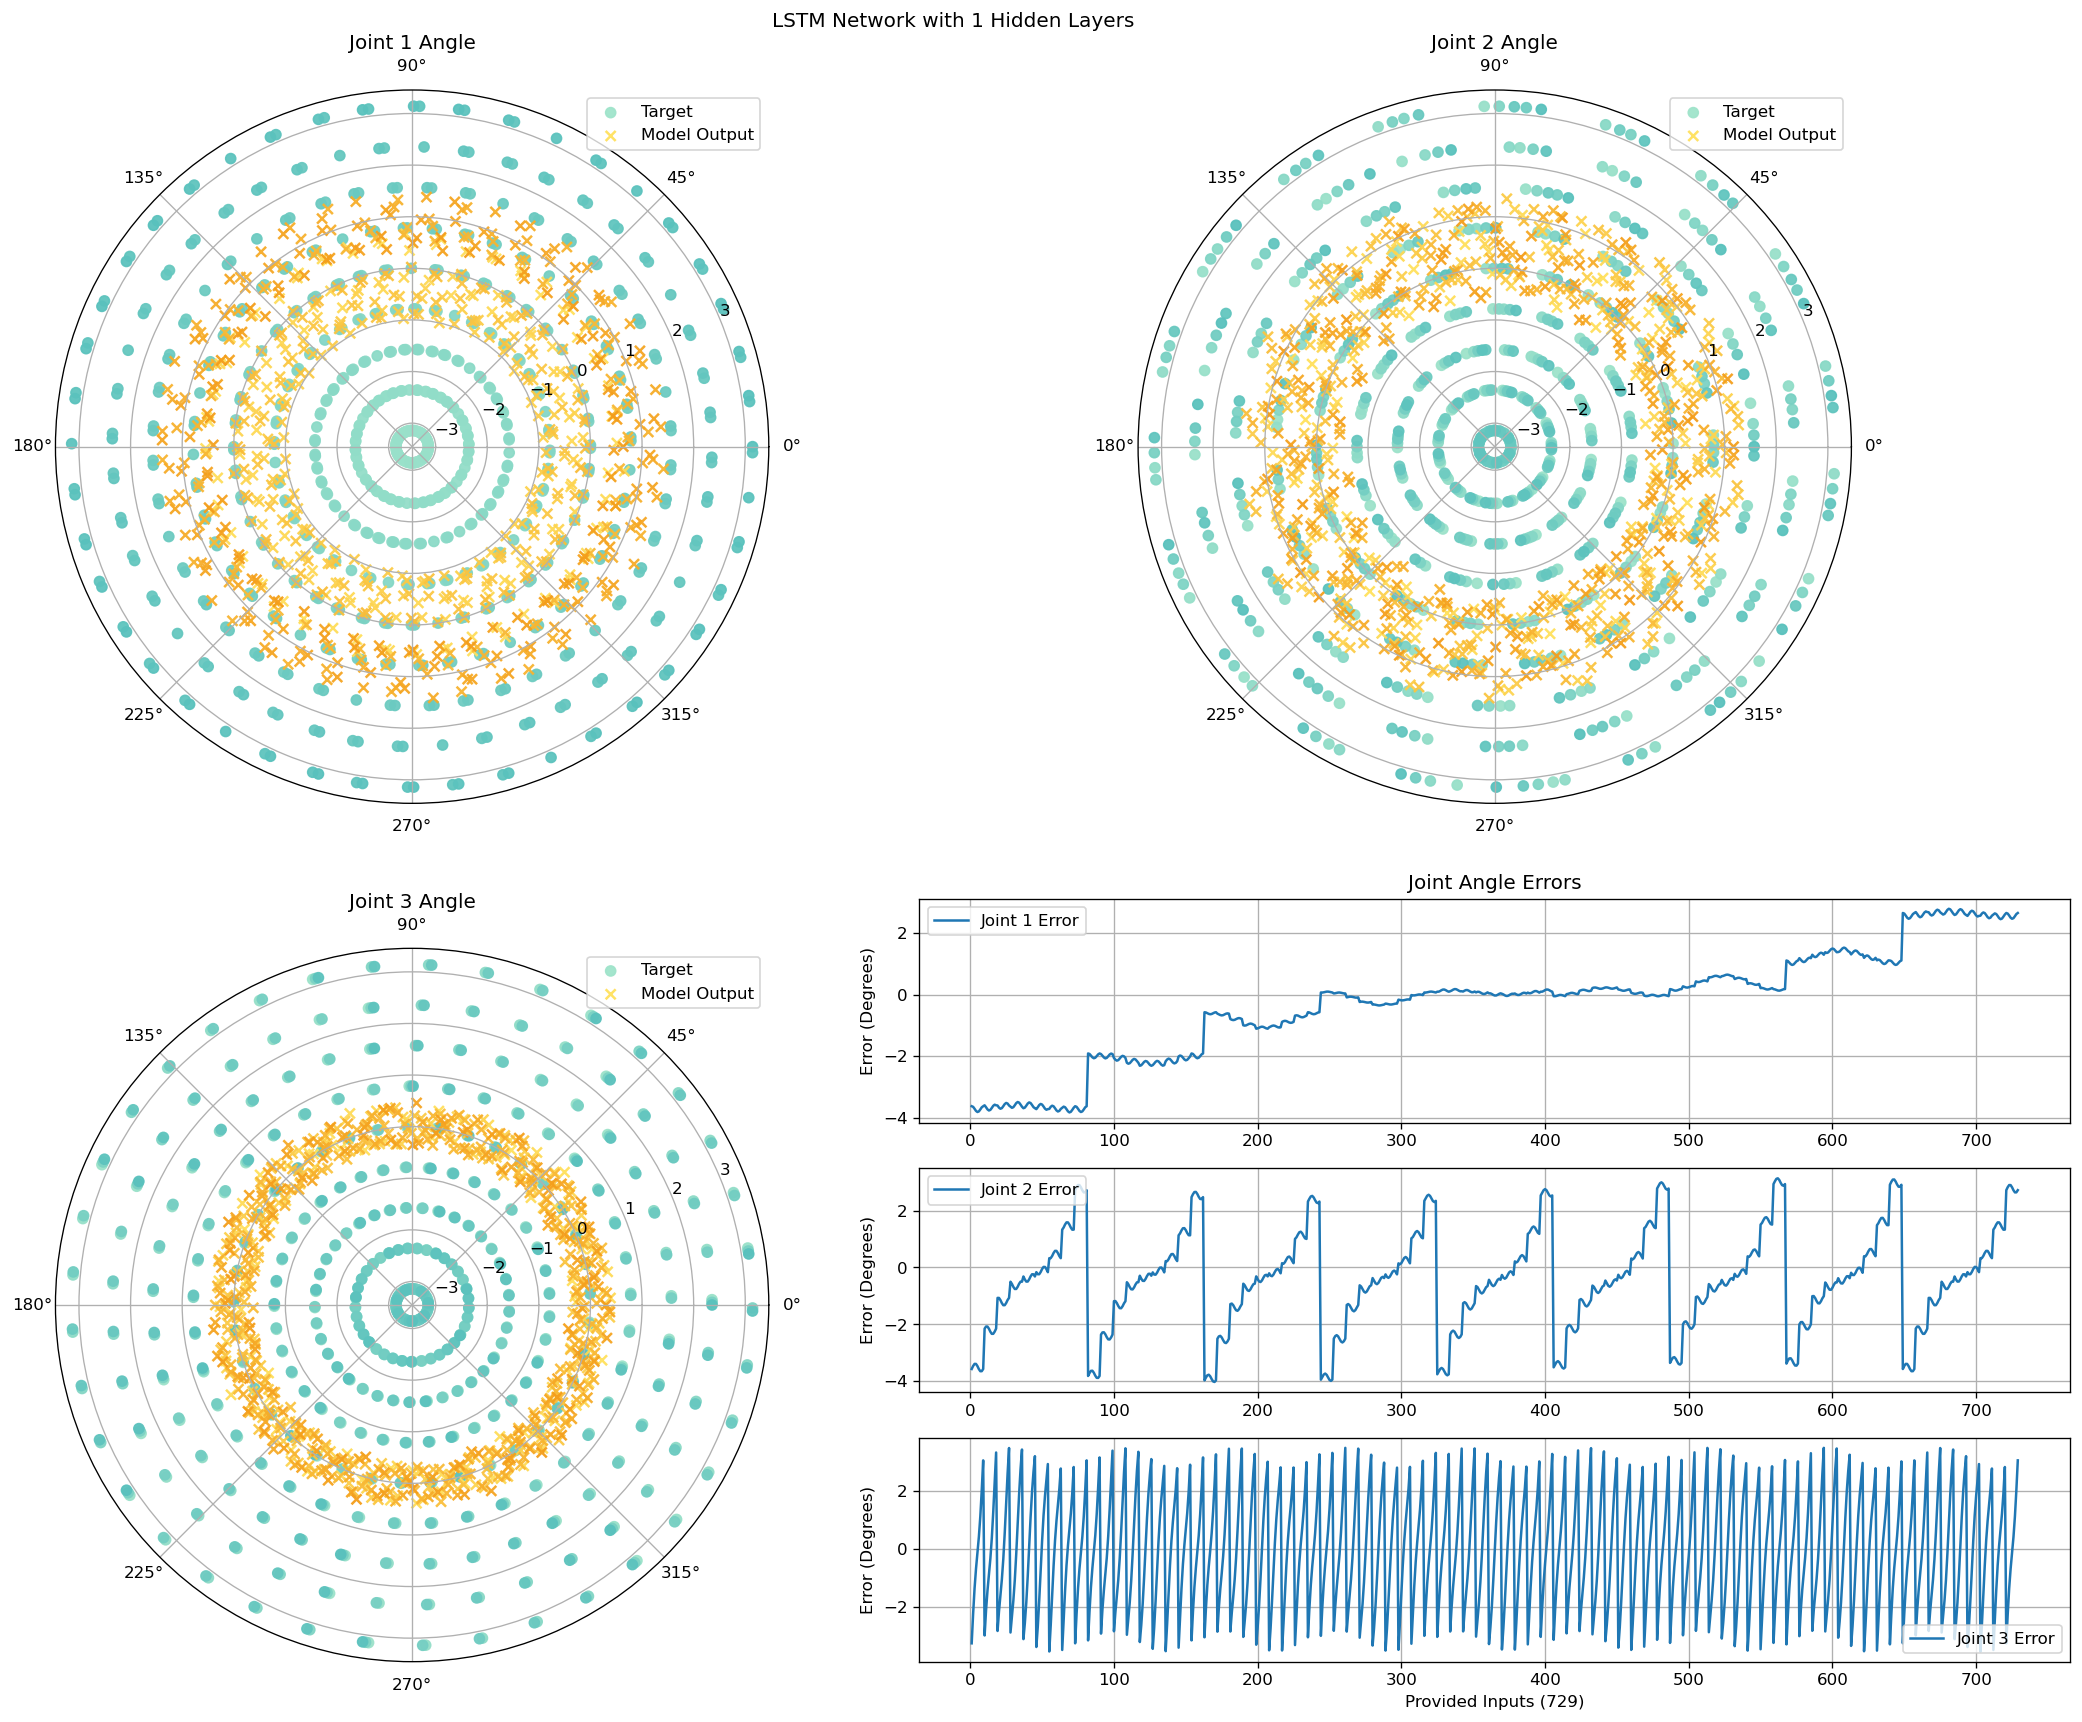

In [253]:
#Colour Gradient stuff        
def hex_to_RGB(hex_str):
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_colour_gradient(c1, c2, n):
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]        

colour1 = "#A0E4CB"
colour2 = "#59C1BD"
colour3 = "#FFE15D"
colour4 = "#F49D1A"

x1 = np.linspace(1, len(y_train), num=len(y_train));

grad1 = get_colour_gradient(colour1, colour2, len(x1))
grad2 = get_colour_gradient(colour3, colour4, len(x1))

#Checking Model        
predicted = pd.DataFrame(model(torch.from_numpy(x_train)).detach().numpy() )
verif = pd.DataFrame(y_train)

#Creating four polar graphs but only need 3
fig, axs = plt.subplots(2, 2, subplot_kw=dict(projection="polar") , figsize=(20, 15), dpi=120)
fig.tight_layout(pad=5)
fig.suptitle("LSTM Network with {} Hidden Layers".format(num_layers))

axs[0, 0].scatter(x1, verif.iloc[:,0].to_numpy(), c=grad1, marker='o', cmap='hsv', alpha=0.95, label='Target')
axs[0, 1].scatter(x1, verif.iloc[:,1].to_numpy(), c=grad1, marker='o', cmap='hsv', alpha=0.95, label='Target')
axs[1, 0].scatter(x1, verif.iloc[:,2].to_numpy(), c=grad1, marker='o', cmap='hsv', alpha=0.95, label='Target')

axs[0, 0].scatter(x1, predicted.iloc[:,0].to_numpy(), c=grad2, marker='x', cmap='hsv', alpha=0.95, label='Model Output')
axs[0, 1].scatter(x1, predicted.iloc[:,1].to_numpy(), c=grad2, marker='x', cmap='hsv', alpha=0.95, label='Model Output')
axs[1, 0].scatter(x1, predicted.iloc[:,2].to_numpy(), c=grad2, marker='x', cmap='hsv', alpha=0.95, label='Model Output')

axs[0, 0].legend()
axs[0, 0].set_title('Joint 1 Angle')
axs[0, 1].legend()
axs[0, 1].set_title('Joint 2 Angle')
axs[1, 0].legend()
axs[1, 0].set_title('Joint 3 Angle')

axs[1,1].remove()
ax = fig.add_subplot(6, 2, 8)
ax.plot(x1, verif.iloc[:,0].to_numpy()-predicted.iloc[:,0].to_numpy(), label='Joint 1 Error')

ax2 = fig.add_subplot(6, 2, 10)
ax2.plot(x1, verif.iloc[:,1].to_numpy()-predicted.iloc[:,1].to_numpy(), label='Joint 2 Error')

ax3 = fig.add_subplot(6, 2, 12)
ax3.plot(x1, verif.iloc[:,2].to_numpy()-predicted.iloc[:,2].to_numpy(), label='Joint 3 Error')

ax.legend()
ax.grid("on")
ax.set_ylabel("Error (Degrees)")

ax2.legend()
ax2.grid("on")
ax2.set_ylabel("Error (Degrees)")

ax3.legend()
ax3.grid("on")
ax3.set_xlabel("Provided Inputs ({})".format(len(y_train)))
ax3.set_ylabel("Error (Degrees)")

ax.set_title('Joint Angle Errors')


plt.show()

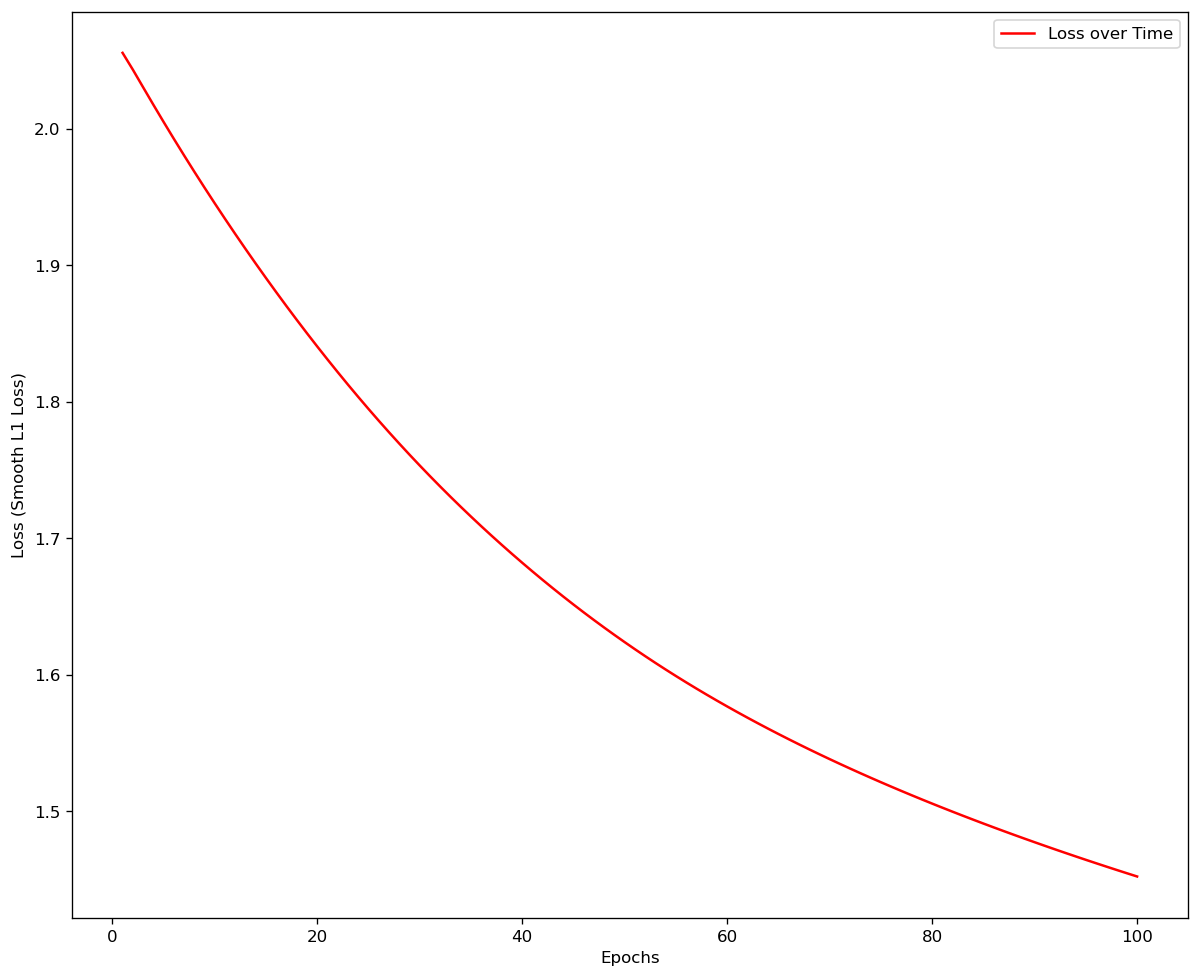

In [254]:
x1 = np.linspace(1, len(lossTrack), num=len(lossTrack));

plt.figure(figsize=(12, 10), dpi=120)
plt.plot(x1, lossTrack, 'r-', label='Loss over Time')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss (Smooth L1 Loss)")
plt.show()



In [188]:
lossTrack[99]

0.3602232336997986

In [255]:
verif.shape

(729, 3)

In [256]:

#save data 

data = [ {'Target': verif , 'Generated': predicted,  'Loss': lossTrack} ]

temp = pd.DataFrame.from_records(data)

#For star up run this : 
#All_the_data = pd.DataFrame.from_records(data)

In [257]:
temp1 = all_the_data


In [258]:
all_the_data = np.append(temp1,[temp])

In [259]:
all_the_data.shape

(30,)

In [ ]:
'''
Order of all_the_data 

Basic Data:
    Target
    Generated
    Loss
Extra Data:
    Target
    Generated
    Loss
Sparse basic data:
    Target
    Generated
    Loss
unique basic data:
    Target
    Generated
    Loss   
Hyper Data:
    Target
    Generated
    Loss
  
Basic Data + 0.2 dropout on model:
    Target
    Generated
    Loss
Basic Data + Layer Norm on model:
    Target
    Generated
    Loss
Basic Data + 5 hiden Layer LSTM model:
    Target
    Generated
    Loss
Basic Data + 1 hiden Layer LSTM model:
    Target
    Generated
    Loss
Basic Data + 1 Layer Linear model:
    Target
    Generated
    Loss

    
'''

Text(0.5, 1.0, 'Joint Angle Errors')

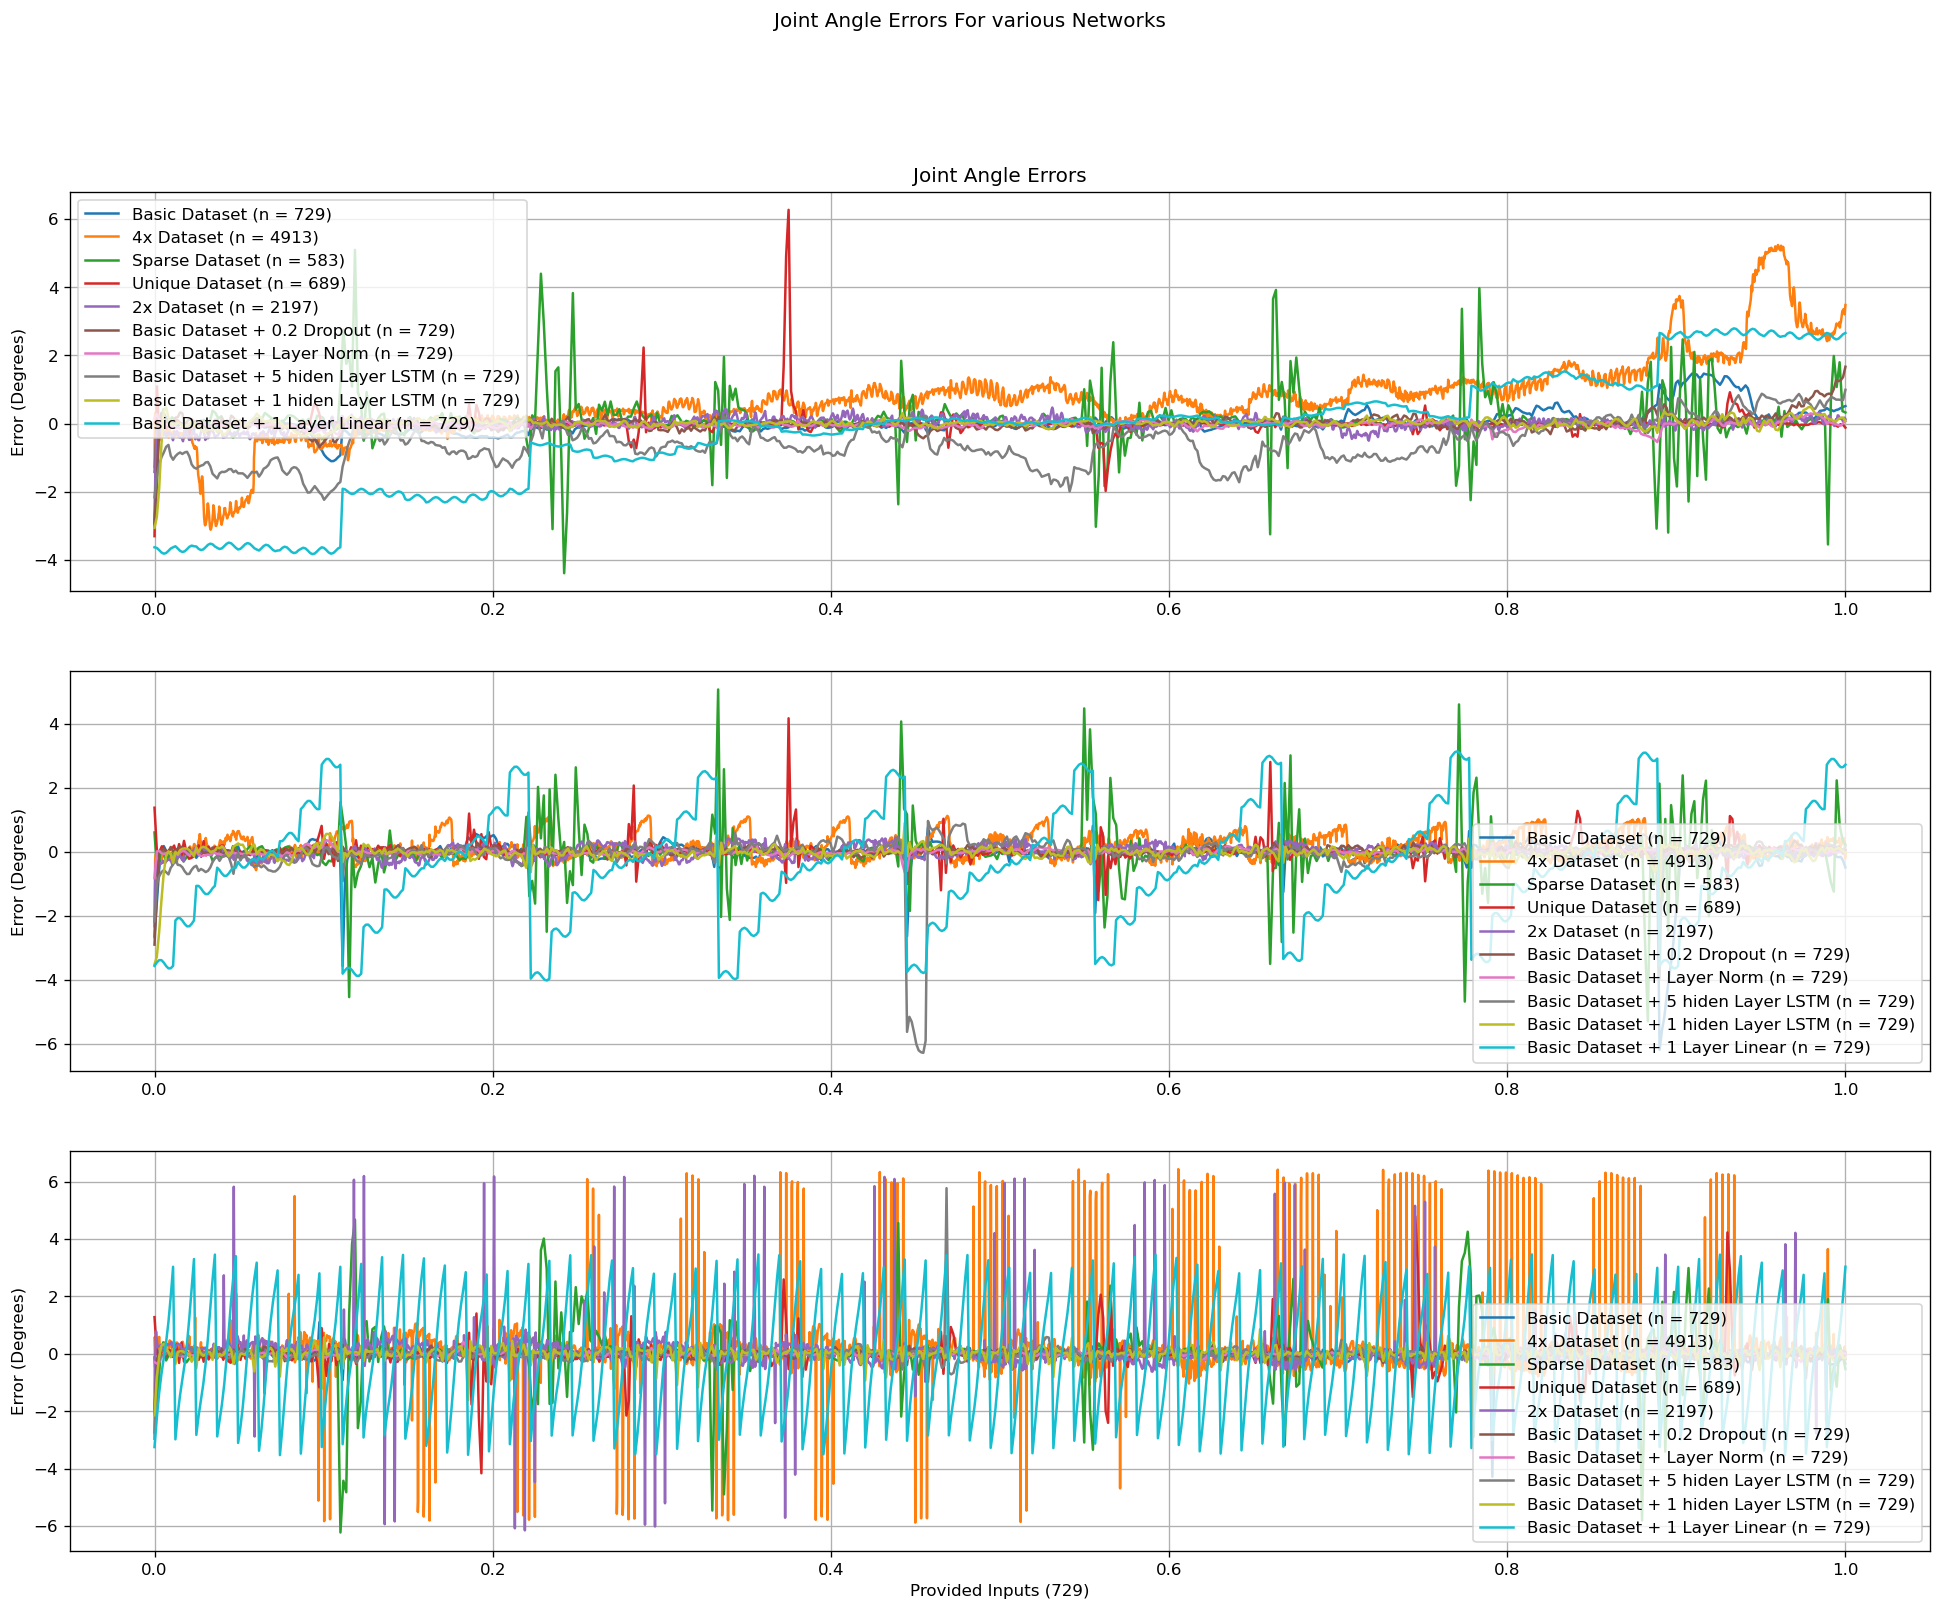

In [305]:
fig= plt.figure( figsize=(20, 15), dpi=120)
fig.tight_layout(pad=5)
fig.suptitle("Joint Angle Errors For various Networks")


ax = fig.add_subplot(3, 1, 1)
#Basic Dataset
ax.plot(np.linspace(0, 1,num=len(np.array(all_the_data[0][0]))), 
        np.array(all_the_data[0][0])-np.array(all_the_data[1][0]), 
        label='Basic Dataset (n = {})'.format(len(np.array(all_the_data[0][0]))))

#hyper Dataset
ax.plot(np.linspace(0, 1,num=len(np.array(all_the_data[3][0]))), 
        np.array(all_the_data[3][0])-np.array(all_the_data[4][0]), 
        label='4x Dataset (n = {})'.format(len(np.array(all_the_data[3][0]))))

#Sparse Dataset
ax.plot(np.linspace(0, 1,num=len(np.array(all_the_data[6][0]))), 
        np.array(all_the_data[6][0])-np.array(all_the_data[7][0]), 
        label='Sparse Dataset (n = {})'.format(len(np.array(all_the_data[6][0]))))

#Unique Dataset
ax.plot(np.linspace(0, 1,num=len(np.array(all_the_data[9][0]))), 
        np.array(all_the_data[9][0])-np.array(all_the_data[10][0]), 
        label='Unique Dataset (n = {})'.format(len(np.array(all_the_data[9][0]))))

#extra Dataset
ax.plot(np.linspace(0, 1,num=len(np.array(all_the_data[12][0]))), 
        np.array(all_the_data[12][0])-np.array(all_the_data[13][0]), 
        label='2x Dataset (n = {})'.format(len(np.array(all_the_data[12][0]))))

#Basic Data + 0.2 dropout
ax.plot(np.linspace(0, 1,num=len(np.array(all_the_data[15][0]))), 
        np.array(all_the_data[15][0])-np.array(all_the_data[16][0]), 
        label='Basic Dataset + 0.2 Dropout (n = {})'.format(len(np.array(all_the_data[15][0]))))

#Basic Data + Layer Norm
ax.plot(np.linspace(0, 1,num=len(np.array(all_the_data[18][0]))), 
        np.array(all_the_data[18][0])-np.array(all_the_data[19][0]), 
        label='Basic Dataset + Layer Norm (n = {})'.format(len(np.array(all_the_data[18][0]))))

#Basic Data + 5 hiden Layer LSTM model:
ax.plot(np.linspace(0, 1,num=len(np.array(all_the_data[21][0]))), 
        np.array(all_the_data[21][0])-np.array(all_the_data[22][0]), 
        label='Basic Dataset + 5 hiden Layer LSTM (n = {})'.format(len(np.array(all_the_data[21][0]))))

#Basic Data + 1 hiden Layer LSTM model:
ax.plot(np.linspace(0, 1,num=len(np.array(all_the_data[24][0]))), 
        np.array(all_the_data[24][0])-np.array(all_the_data[25][0]), 
        label='Basic Dataset + 1 hiden Layer LSTM (n = {})'.format(len(np.array(all_the_data[24][0]))))

#Basic Data + 1 Layer Linear model:
ax.plot(np.linspace(0, 1,num=len(np.array(all_the_data[27][0]))), 
        np.array(all_the_data[27][0])-np.array(all_the_data[28][0]), 
        label='Basic Dataset + 1 Layer Linear (n = {})'.format(len(np.array(all_the_data[27][0]))))

ax2 = fig.add_subplot(3, 1, 2)
#Basic Dataset
ax2.plot(np.linspace(0, 1,num=len(np.array(all_the_data[0][1]))), 
         np.array(all_the_data[0][1])-np.array(all_the_data[1][1]), 
         label='Basic Dataset (n = {})'.format(len(np.array(all_the_data[0][1]))))

#hyper Dataset
ax2.plot(np.linspace(0, 1,num=len(np.array(all_the_data[3][1]))), 
        np.array(all_the_data[3][1])-np.array(all_the_data[4][1]), 
        label='4x Dataset (n = {})'.format(len(np.array(all_the_data[3][1]))))

#Sparse Dataset
ax2.plot(np.linspace(0, 1,num=len(np.array(all_the_data[6][1]))), 
        np.array(all_the_data[6][1])-np.array(all_the_data[7][1]), 
        label='Sparse Dataset (n = {})'.format(len(np.array(all_the_data[6][1]))))

#Unique Dataset
ax2.plot(np.linspace(0, 1,num=len(np.array(all_the_data[9][1]))), 
        np.array(all_the_data[9][1])-np.array(all_the_data[10][1]), 
        label='Unique Dataset (n = {})'.format(len(np.array(all_the_data[9][1]))))

#extra Dataset
ax2.plot(np.linspace(0, 1,num=len(np.array(all_the_data[12][1]))), 
        np.array(all_the_data[12][1])-np.array(all_the_data[13][1]), 
        label='2x Dataset (n = {})'.format(len(np.array(all_the_data[12][1]))))

#Basic Data + 0.2 dropout
ax2.plot(np.linspace(0, 1,num=len(np.array(all_the_data[15][1]))), 
        np.array(all_the_data[15][1])-np.array(all_the_data[16][1]), 
        label='Basic Dataset + 0.2 Dropout (n = {})'.format(len(np.array(all_the_data[15][1]))))

#Basic Data + Layer Norm
ax2.plot(np.linspace(0, 1,num=len(np.array(all_the_data[18][1]))), 
        np.array(all_the_data[18][1])-np.array(all_the_data[19][1]), 
        label='Basic Dataset + Layer Norm (n = {})'.format(len(np.array(all_the_data[18][1]))))

#Basic Data + 5 hiden Layer LSTM model:
ax2.plot(np.linspace(0, 1,num=len(np.array(all_the_data[21][1]))), 
        np.array(all_the_data[21][1])-np.array(all_the_data[22][1]), 
        label='Basic Dataset + 5 hiden Layer LSTM (n = {})'.format(len(np.array(all_the_data[21][1]))))

#Basic Data + 1 hiden Layer LSTM model:
ax2.plot(np.linspace(0, 1,num=len(np.array(all_the_data[24][1]))), 
        np.array(all_the_data[24][1])-np.array(all_the_data[25][1]), 
        label='Basic Dataset + 1 hiden Layer LSTM (n = {})'.format(len(np.array(all_the_data[24][1]))))

#Basic Data + 1 Layer Linear model:
ax2.plot(np.linspace(0, 1,num=len(np.array(all_the_data[27][1]))), 
        np.array(all_the_data[27][1])-np.array(all_the_data[28][1]), 
        label='Basic Dataset + 1 Layer Linear (n = {})'.format(len(np.array(all_the_data[27][1]))))

ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(np.linspace(0, 1,num=len(np.array(all_the_data[0][2]))), 
         np.array(all_the_data[0][2])-np.array(all_the_data[1][2]), 
         label='Basic Dataset (n = {})'.format(len(np.array(all_the_data[0][2]))))

#hyper Dataset
ax3.plot(np.linspace(0, 1,num=len(np.array(all_the_data[3][2]))), 
        np.array(all_the_data[3][2])-np.array(all_the_data[4][2]), 
        label='4x Dataset (n = {})'.format(len(np.array(all_the_data[3][2]))))

#Sparse Dataset
ax3.plot(np.linspace(0, 1,num=len(np.array(all_the_data[6][2]))), 
        np.array(all_the_data[6][2])-np.array(all_the_data[7][2]), 
        label='Sparse Dataset (n = {})'.format(len(np.array(all_the_data[6][2]))))

#Unique Dataset
ax3.plot(np.linspace(0, 1,num=len(np.array(all_the_data[9][2]))), 
        np.array(all_the_data[9][2])-np.array(all_the_data[10][2]), 
        label='Unique Dataset (n = {})'.format(len(np.array(all_the_data[9][2]))))

#extra Dataset
ax3.plot(np.linspace(0, 1,num=len(np.array(all_the_data[12][2]))), 
        np.array(all_the_data[12][2])-np.array(all_the_data[13][2]), 
        label='2x Dataset (n = {})'.format(len(np.array(all_the_data[12][2]))))

#Basic Data + 0.2 dropout
ax3.plot(np.linspace(0, 1,num=len(np.array(all_the_data[15][2]))), 
        np.array(all_the_data[15][2])-np.array(all_the_data[16][2]), 
        label='Basic Dataset + 0.2 Dropout (n = {})'.format(len(np.array(all_the_data[15][2]))))

#Basic Data + Layer Norm
ax3.plot(np.linspace(0, 1,num=len(np.array(all_the_data[18][2]))), 
        np.array(all_the_data[18][2])-np.array(all_the_data[19][2]), 
        label='Basic Dataset + Layer Norm (n = {})'.format(len(np.array(all_the_data[18][2]))))

#Basic Data + 5 hiden Layer LSTM model:
ax3.plot(np.linspace(0, 1,num=len(np.array(all_the_data[21][2]))), 
        np.array(all_the_data[21][2])-np.array(all_the_data[22][2]), 
        label='Basic Dataset + 5 hiden Layer LSTM (n = {})'.format(len(np.array(all_the_data[21][2]))))

#Basic Data + 1 hiden Layer LSTM model:
ax3.plot(np.linspace(0, 1,num=len(np.array(all_the_data[24][2]))), 
        np.array(all_the_data[24][2])-np.array(all_the_data[25][2]), 
        label='Basic Dataset + 1 hiden Layer LSTM (n = {})'.format(len(np.array(all_the_data[24][2]))))

#Basic Data + 1 Layer Linear model:
ax3.plot(np.linspace(0, 1,num=len(np.array(all_the_data[27][2]))), 
        np.array(all_the_data[27][2])-np.array(all_the_data[28][2]), 
        label='Basic Dataset + 1 Layer Linear (n = {})'.format(len(np.array(all_the_data[27][2]))))

ax.legend()
ax.grid("on")
ax.set_ylabel("Error (Degrees)")

ax2.legend()
ax2.grid("on")
ax2.set_ylabel("Error (Degrees)")

ax3.legend()
ax3.grid("on")
ax3.set_xlabel("Provided Inputs ({})".format(len(y_train)))
ax3.set_ylabel("Error (Degrees)")

ax.set_title('Joint Angle Errors')

Text(0.5, 1.0, 'Joint Angle Errors')

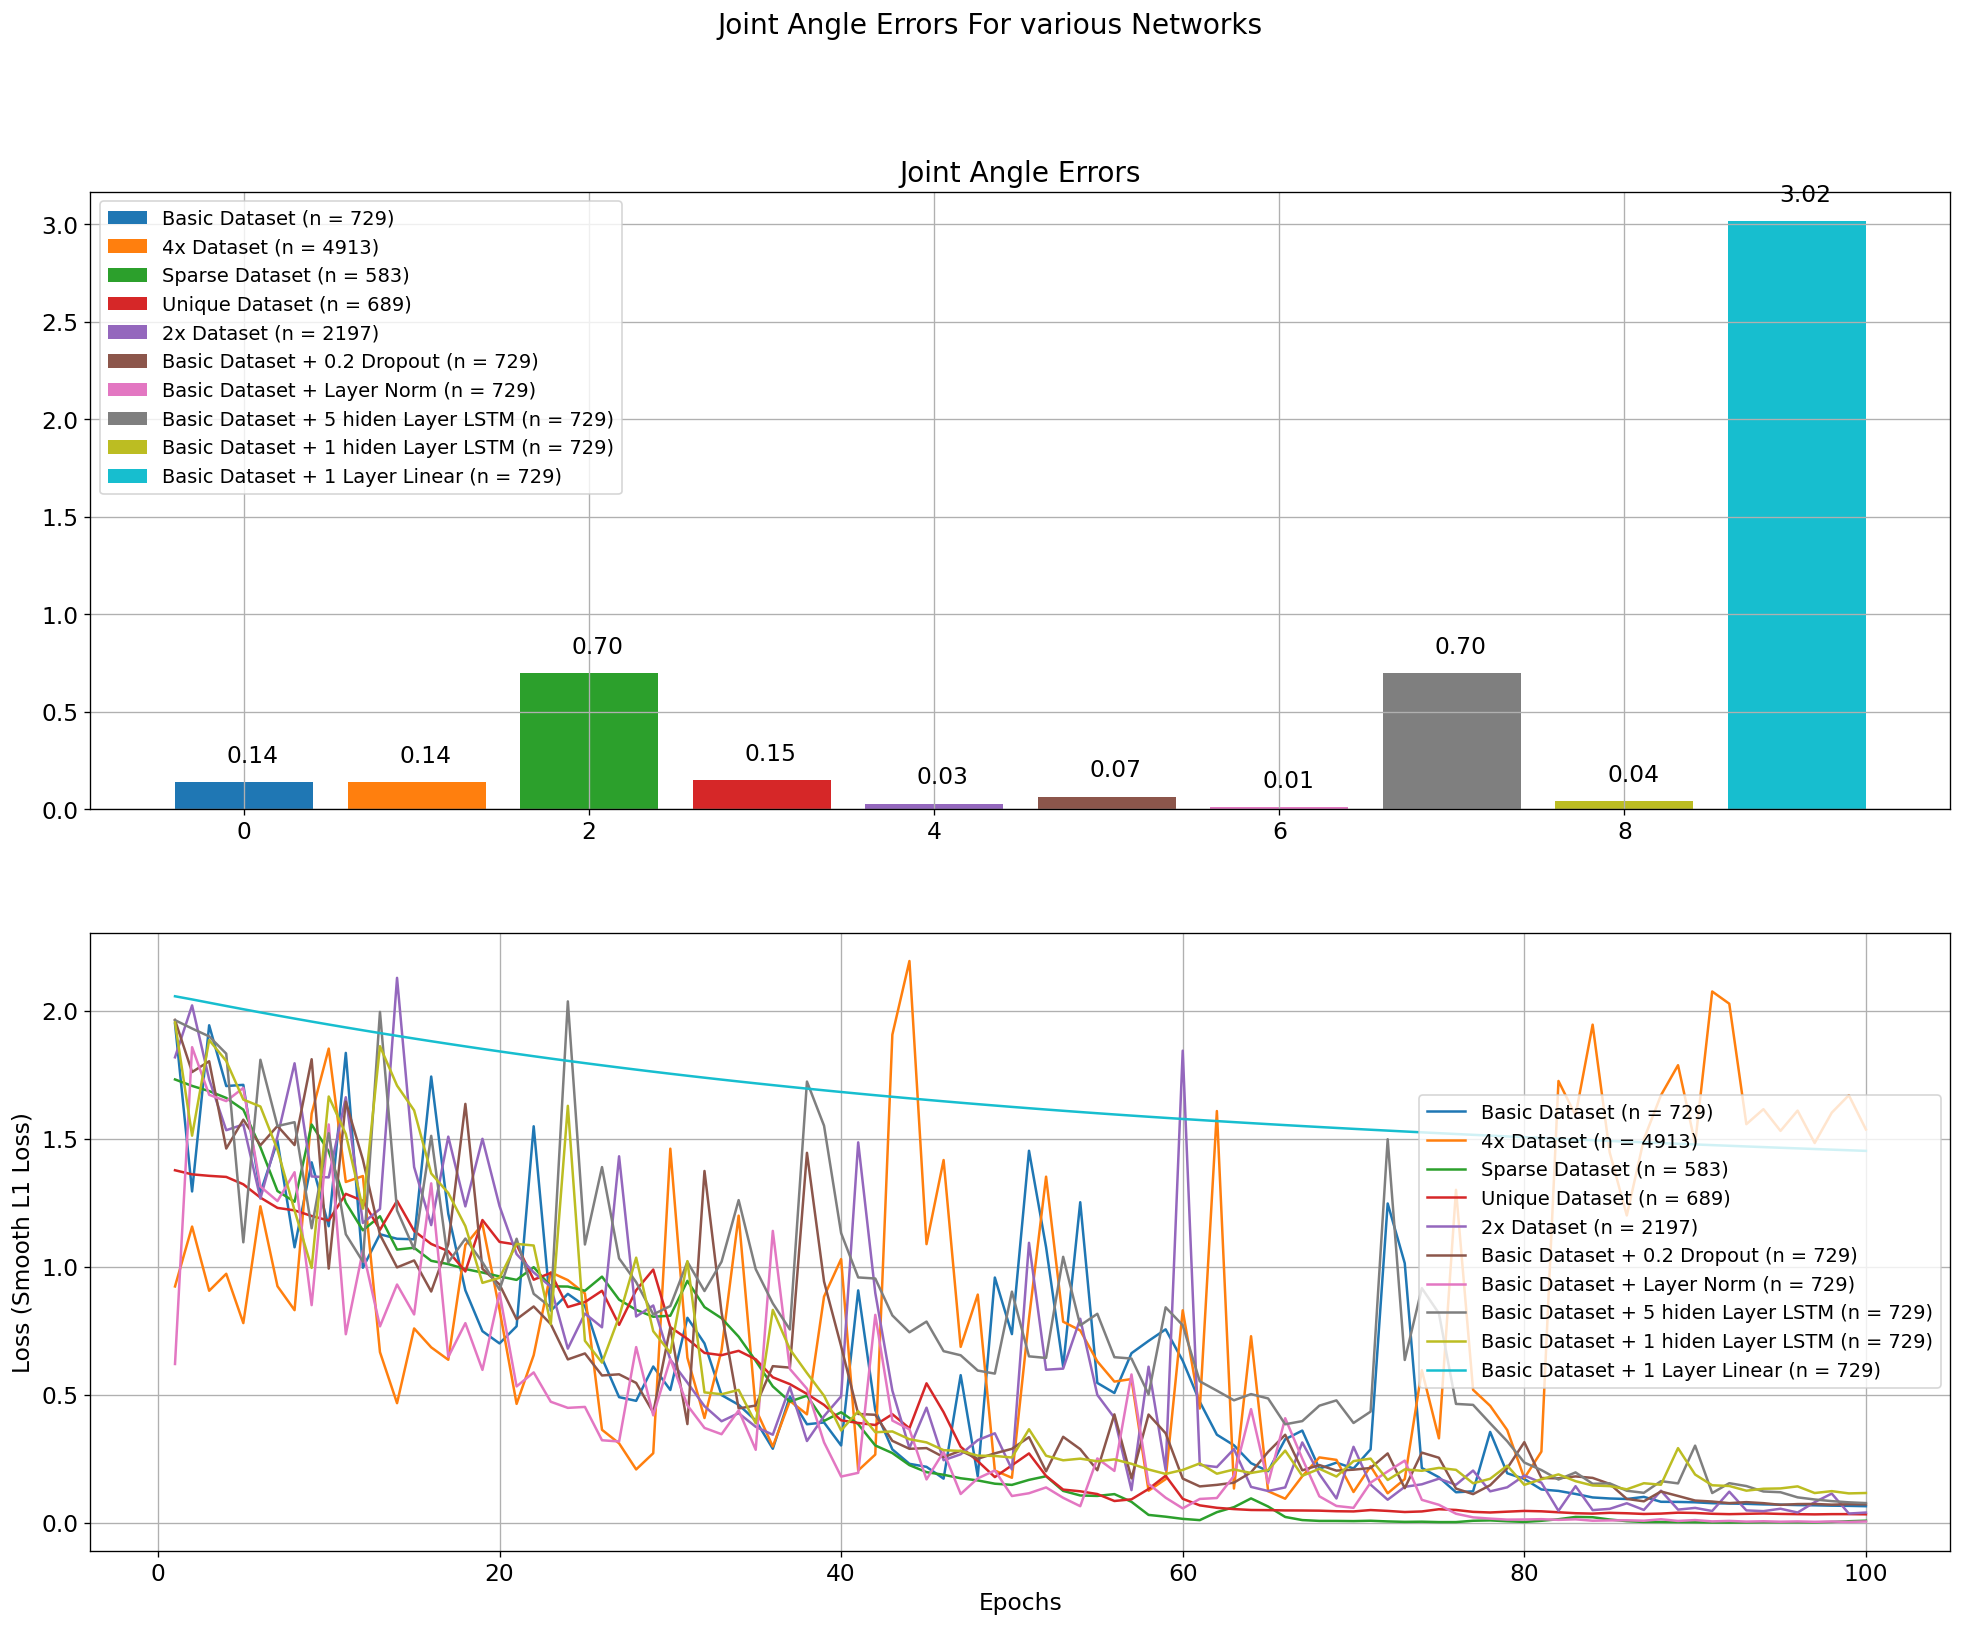

In [344]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(20, 15), dpi=120)
fig.tight_layout()
fig.suptitle("Joint Angle Errors For various Networks")


ax = fig.add_subplot(2, 1, 1)
#Basic Dataset
val = np.square(np.subtract( np.array(all_the_data[0][0]), np.array(all_the_data[1][0]) )).mean()
bars = ax.bar(0, val, label='Basic Dataset (n = {})'.format(len(np.array(all_the_data[0][0]))))
ax.text(0-0.1, val+0.1, '{:.2f}'.format(val))

#hyper Dataset
val = np.square(np.subtract( np.array(all_the_data[0][0]), np.array(all_the_data[1][0]) )).mean()
ax.bar(1, val, label='4x Dataset (n = {})'.format(len(np.array(all_the_data[3][0]))))
ax.text(1-0.1, val+0.1, '{:.2f}'.format(val))

#Sparse Dataset
val = np.square(np.subtract( np.array(all_the_data[6][0]), np.array(all_the_data[7][0]) )).mean()
ax.bar(2, val, label='Sparse Dataset (n = {})'.format(len(np.array(all_the_data[6][0]))))
ax.text(2-0.1, val+0.1, '{:.2f}'.format(val))

#Unique Dataset
val = np.square(np.subtract( np.array(all_the_data[9][0]), np.array(all_the_data[10][0]) )).mean()
ax.bar(3, val, label='Unique Dataset (n = {})'.format(len(np.array(all_the_data[9][0]))))
ax.text(3-0.1, val+0.1, '{:.2f}'.format(val))

#extra Dataset
val = np.square(np.subtract( np.array(all_the_data[12][0]), np.array(all_the_data[13][0]) )).mean()
ax.bar(4, val, label='2x Dataset (n = {})'.format(len(np.array(all_the_data[12][0]))))
ax.text(4-0.1, val+0.1, '{:.2f}'.format(val))

#Basic Data + 0.2 dropout
val = np.square(np.subtract( np.array(all_the_data[15][0]), np.array(all_the_data[16][0]) )).mean()
ax.bar(5, val, label='Basic Dataset + 0.2 Dropout (n = {})'.format(len(np.array(all_the_data[15][0]))))
ax.text(5-0.1, val+0.1, '{:.2f}'.format(val))

#Basic Data + Layer Norm
val = np.square(np.subtract( np.array(all_the_data[18][0]), np.array(all_the_data[19][0]) )).mean()
ax.bar(6, val, label='Basic Dataset + Layer Norm (n = {})'.format(len(np.array(all_the_data[18][0]))))
ax.text(6-0.1, val+0.1, '{:.2f}'.format(val))

#Basic Data + 5 hiden Layer LSTM model:
val = np.square(np.subtract( np.array(all_the_data[21][0]), np.array(all_the_data[22][0]) )).mean()
ax.bar(7, val, label='Basic Dataset + 5 hiden Layer LSTM (n = {})'.format(len(np.array(all_the_data[21][0]))))
ax.text(7-0.1, val+0.1, '{:.2f}'.format(val))

#Basic Data + 1 hiden Layer LSTM model:
val = np.square(np.subtract( np.array(all_the_data[24][0]), np.array(all_the_data[25][0]) )).mean()
ax.bar(8, val, label='Basic Dataset + 1 hiden Layer LSTM (n = {})'.format(len(np.array(all_the_data[24][0]))))
ax.text(8-0.1, val+0.1, '{:.2f}'.format(val))

#Basic Data + 1 Layer Linear model:
val = np.square(np.subtract( np.array(all_the_data[27][0]), np.array(all_the_data[28][0]) )).mean()
ax.bar(9, val, label='Basic Dataset + 1 Layer Linear (n = {})'.format(len(np.array(all_the_data[27][0]))))
ax.text(9-0.1, val+0.1, '{:.2f}'.format(val))

x1 = np.linspace( 1, len(np.array(all_the_data[2])), num=len(np.array(all_the_data[2])) );
ax2 = fig.add_subplot(2, 1, 2)
#Basic Dataset
ax2.plot(x1, 
         np.array(all_the_data[2]), 
         label='Basic Dataset (n = {})'.format(len(np.array(all_the_data[0][1]))))

#hyper Dataset
ax2.plot(x1, np.array(all_the_data[5]), 
        label='4x Dataset (n = {})'.format(len(np.array(all_the_data[3][1]))))

#Sparse Dataset
ax2.plot(x1, np.array(all_the_data[8]), 
        label='Sparse Dataset (n = {})'.format(len(np.array(all_the_data[6][1]))))

#Unique Dataset
ax2.plot(x1, np.array(all_the_data[11]), 
        label='Unique Dataset (n = {})'.format(len(np.array(all_the_data[9][1]))))

#extra Dataset
ax2.plot(x1, np.array(all_the_data[14]), 
        label='2x Dataset (n = {})'.format(len(np.array(all_the_data[12][1]))))

#Basic Data + 0.2 dropout
ax2.plot(x1, np.array(all_the_data[17]), 
        label='Basic Dataset + 0.2 Dropout (n = {})'.format(len(np.array(all_the_data[15][1]))))

#Basic Data + Layer Norm
ax2.plot(x1, np.array(all_the_data[20]), 
        label='Basic Dataset + Layer Norm (n = {})'.format(len(np.array(all_the_data[18][1]))))

#Basic Data + 5 hiden Layer LSTM model:
ax2.plot(x1, np.array(all_the_data[23]), 
        label='Basic Dataset + 5 hiden Layer LSTM (n = {})'.format(len(np.array(all_the_data[21][1]))))

#Basic Data + 1 hiden Layer LSTM model:
ax2.plot(x1, np.array(all_the_data[26]), 
        label='Basic Dataset + 1 hiden Layer LSTM (n = {})'.format(len(np.array(all_the_data[24][1]))))

#Basic Data + 1 Layer Linear model:
ax2.plot(x1, np.array(all_the_data[29]), 
        label='Basic Dataset + 1 Layer Linear (n = {})'.format(len(np.array(all_the_data[27][1]))))


ax.legend(fontsize = 'small')
ax.grid("on")
plt.xlabel("Epochs")
plt.ylabel("Loss (Smooth L1 Loss)")

ax2.legend(fontsize = 'small')
ax2.grid("on")
ax2.set_ylabel("Loss (Smooth L1 Loss)")

ax.set_title('Joint Angle Errors')

In [345]:
len(all_the_data[2])

100

In [387]:
print("\n".join( [str(x) for x in all_the_data[25][2] ] ))

-1.0022037029266357
-1.5681577920913696
-1.4673014879226685
-1.07552170753479
-0.34742313623428345
0.5633674263954163
1.5056989192962646
2.4736385345458984
2.9744811058044434
-2.787976026535034
-2.412482976913452
-1.6657308340072632
-0.8805082440376282
-0.04281629994511604
0.767599880695343
1.5850489139556885
2.6297707557678223
3.2055537700653076
-2.636979341506958
-2.5488176345825195
-1.5844484567642212
-0.7185030579566956
0.02605077251791954
0.7098740935325623
1.5237884521484375
2.563819169998169
2.804757595062256
-3.017824411392212
-2.3512158393859863
-1.5118050575256348
-0.7761993408203125
-0.14922650158405304
0.5265904664993286
1.4286442995071411
2.7029829025268555
3.1310441493988037
-2.916825532913208
-2.3539488315582275
-1.5644763708114624
-0.7622364163398743
-0.06892794370651245
0.6475806832313538
1.6010304689407349
2.970383882522583
2.854283094406128
-3.058980703353882
-2.243426561355591
-1.4827572107315063
-0.7726009488105774
-0.13340675830841064
0.5727776288986206
1.47395741